#### Notebook to optimize CP parameters based on variance of log(K) values within each layer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import utm
import matplotlib.pyplot as plt
from scipy import stats
import ruptures as rpt
from pykrige.ok import OrdinaryKriging
from shapely.geometry import LineString, Point
from scipy.io import loadmat

from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, SBT_from_Ic, k_from_Ic, setup_grid

In [2]:
def detect_change_points(values, model="rbf", penalty=10):
    ''' Apply the PELT change point detection algorithm
    '''
    algo = rpt.Pelt(model=model).fit(values)
    change_points = algo.predict(pen=penalty)
    return change_points

In [3]:
points = setup_grid(geoplot='./geojson/alameda_city.geojson')
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')
points = points.dropna(subset=['utmX', 'utmY'])


c:\users\emily\documents\github\hydro_conduct_working\regional_k\regional_K\cpt_functions.py:418: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  points = pd.concat([points, pd.DataFrame([[lat, lon, utmX, utmY]], columns=['lat', 'lon', 'utmX', 'utmY'])])


In [4]:
import os
os.getcwd()

'c:\\Users\\Emily\\Documents\\GitHub\\hydro_conduct_working'

In [5]:
cpt = setup_cpt('./USGS_CPT_data/')
cpt = soil_stress(cpt)
calc_SBT(cpt)
# for _, data in cpt.items():
#     data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
#     data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])

### This section overwrites the CPT_data with inverse filter values
for bh in cpt:
    try:
        data = loadmat(f'./corrected_cpts/FoS_OUT_{bh}.mat')

        cpt[bh]['CPT_data'] = pd.DataFrame()
        cpt[bh]['CPT_data']['d'] = data['FoS_OUT'][0][0]['depth'][0][0].squeeze()
        cpt[bh]['CPT_data']['Ic'] = data['FoS_OUT'][0][0]['Ic'][0][0].squeeze()
        cpt[bh]['CPT_data']['qc1nc'] = data['FoS_OUT'][0][0]['qc1n_cs1'][0][0].squeeze()
        cpt[bh]['CPT_data']['fs'] = data['FoS_OUT'][0][0]['fs'][0][0].squeeze()
        cpt[bh]['CPT_data']['SBT'], _ = SBT_from_Ic(cpt[bh]['CPT_data']['Ic'])
        cpt[bh]['CPT_data']['k_fromIc'] = k_from_Ic(cpt[bh]['CPT_data']['Ic'])
    except:
        print('No corrected data for ', bh)
        continue

####################################################################

shapefile_path = './deposits_shp/sfq2py.shp'
data = gpd.read_file(shapefile_path)
data.crs = 'EPSG:4326'

cpts_df = pd.DataFrame.from_dict(cpt, orient='index')
cpts_df.drop(['CPT_data'], axis=1, inplace=True)
cpts_gdf = gpd.GeoDataFrame(cpts_df, geometry=gpd.points_from_xy(cpts_df['Lon'], cpts_df['Lat']))
cpts_gdf.crs = 'EPSG:4326'
joined = gpd.sjoin(cpts_gdf, data, how='left')

c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


No corrected data for  Oak037
No corrected data for  Oak038
No corrected data for  Oak039
No corrected data for  Oak040
No corrected data for  Oak041
No corrected data for  Oak042
No corrected data for  Oak043
No corrected data for  Oak044
No corrected data for  Oak045


In [6]:
# remove bhs that start with 'Oak' from cpt
cpt = {key: val for key, val in cpt.items() if not key.startswith('Oak')}


In [137]:
vars = []
maxdepth = []
ybm_var = []
discard = []
diff = []
# no thresholds:
penalties = range(20,68,4)
method = 'MS'  # 'naive' 'MS' 'MS_AF'
af_lim = 6  # max m depth that will be assigned as fill
## one threshold::
# penalties_above = np.linspace(32,50,4)
# penalties_below = np.linspace(18,36,4)
# thresholds = np.linspace(14,36,4)
# iterations = len(penalties_above)*len(penalties_below)*len(thresholds)
# ## two thresholds:
# penalties_0 = np.linspace(8,20, 3)
# penalties_1 = np.linspace(10, 28, 3)
# penalties_2 = np.linspace(18, 36, 3)
# thresholds_1 = np.linspace(16, 20, 3)
# thresholds_2 = np.linspace(22, 32, 3)
# iterations = len(penalties_0) * len(penalties_1) * len(penalties_2) * len(thresholds_1) * len(thresholds_2)

# # for no thresholds
for pen_above in penalties:
    threshold = 0
    pen_below = pen_above
    
# for i in range(iterations):
#     pen_above = penalties_above[(i // (len(penalties_below) * len(thresholds))) % len(penalties_above)]
#     pen_below = penalties_below[(i // len(thresholds)) % len(penalties_below)]
#     threshold = thresholds[i % len(thresholds)]
    # pen_0 = penalties_0[i // (len(penalties_1) * len(penalties_2) * len(thresholds_1) * len(thresholds_2))]
    # pen_1 = penalties_1[(i // (len(penalties_2) * len(thresholds_1) * len(thresholds_2))) % len(penalties_1)]
    # pen_2 = penalties_2[(i // (len(thresholds_1) * len(thresholds_2))) % len(penalties_2)]
    # threshold1 = thresholds_1[(i // len(thresholds_2)) % len(thresholds_1)]
    # threshold2 = thresholds_2[i % len(thresholds_2)]
    
    discard_count = 0
    cp_layers_dict = {}
    results_k_values = {}
    for bh in cpt:
        depth = cpt[bh]['CPT_data']['d']
        sbt = cpt[bh]['CPT_data']['SBT']  # ['CPT_data'] for corrected data
        # Detect change points
        if max(cpt[bh]['CPT_data']['d']) < threshold:
            change_points = detect_change_points(cpt[bh]['CPT_data']['SBT'].values, model="l2", penalty=pen_below)[:-1]
        else:
            change_points = detect_change_points(cpt[bh]['CPT_data']['SBT'].values, model="l2", penalty=pen_above)[:-1]
            
        # # Detect change points for two thresholds
        # if max(cpt[bh]['CPT_data']['d']) < threshold1:
        #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_0)[:-1]
        # elif max(cpt[bh]['CPT_data']['d']) < threshold2:
        #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_1)[:-1]
        # else:
        #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_2)[:-1]
            
        fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0

        # Calculate and plot the average k_fromIc between change points
        change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
        depths = []
        Ks = []
        SBTs = []
        for i in range(len(change_points) - 1):
            start_idx = change_points[i]
            end_idx = change_points[i + 1]

            avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
            avg_SBT = stats.mode(cpt[bh]['CPT_data']['SBT'][start_idx:end_idx])[0]
            start_depth = cpt[bh]['CPT_data']['d'][start_idx]
            end_depth = cpt[bh]['CPT_data']['d'][end_idx]
            SBTs.append(avg_SBT)
            depths.append(end_depth - start_depth)
            Ks.append(avg_k_fromIc)
        ## Naive method:
        if method == 'naive':  
            if fill_flag:
                if len(depths) == 3:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2]}
                elif len(depths) >= 4:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
                elif len(depths) ==2:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': np.nan}
                else:
                    cp_layers_dict[bh] = {'Fill': depths[0],'Young Bay Mud': np.nan, 'Merrit Sand': np.nan} 
            else:
                if len(depths) >=3:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
                elif len(depths) ==2:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1]}
                else:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': np.nan}
        elif method == 'MS':
            if len(depths) == 3 + fill_flag:
                if fill_flag: 
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
                else:
                    cp_layers_dict[bh] = {'Fill':0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
            elif len(depths) > 3 + fill_flag:
                ## this is where we have more layers than expected
                if fill_flag:
                    # sum of depths from fill to merrit sand
                    ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                    if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                    else:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
                else:
                    ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                    if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                    else:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
            elif len(depths) < 3 + fill_flag:
                ## this is where we have fewer layers than expected
                if 6 not in SBTs:
                    print('no sand in', bh)
                    if fill_flag:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]), 'Merrit Sand': np.nan}
                    else:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths), 'Merrit Sand': np.nan}
                else:
                    MS_ind = np.where(np.array(SBTs) == 6)[0][-1]
                    if fill_flag:
                        if len(depths) <=2:
                            print('throwing out', bh)
                            discard_count += 1
                            continue
                        elif MS_ind == 0:
                            ## there is only one layer with SBT 6, assume it is fill
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]), 'Merrit Sand': np.nan}
                        else:
                            if len(depths) > MS_ind+1:
                                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                            else:
                                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind]}
                    else:
                        if len(depths) <=1:
                            print('throwing out', bh)
                            discard_count += 1
                            continue
                        else:
                            if len(depths) > MS_ind+1:
                                cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                            else:
                                cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind]}
        elif method == 'MS_AF':
            if len(depths) == 3 + fill_flag:
                if fill_flag: 
                    if depths[0] <= af_lim:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
                    else:
                        cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
                else:
                    cp_layers_dict[bh] = {'Fill':0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
            if len(depths) > 3 + fill_flag:
                ## we have more layers than expected
                if fill_flag:
                    # sum of depths from fill to merrit sand
                    if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                        if depths[0] <= af_lim:
                            ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                        else:
                            ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                            cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                    else:
                        if depths[0] <= af_lim:
                            ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
                        else:
                            ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                            cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
                else:
                    ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                    if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                    else:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
            elif len(depths) < 3 + fill_flag:
                ## case where we have fewer layers than expected
                try:
                    MS_ind = np.where(np.array(SBTs) == 6)[0][-1]
                except:
                    print('no sand in', bh)
                    continue
                if fill_flag:
                    if len(depths) <=2:
                        print('throwing out', bh)
                        discard_count += 1
                        continue
                    elif MS_ind == 0:
                        ## there is only one layer with SBT 6, check its depth
                        if depths[0] <= af_lim:
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]),'Merrit Sand': np.nan}
                        else:
                            cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': 0, 'Merrit Sand': np.sum(depths[MS_ind]), 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                    else:
                        if len(depths) > MS_ind+1:
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                        else:
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind]}
                else: ## not in fill
                    if len(depths) <=1:
                        print('throwing out', bh)
                        discard_count += 1
                        continue
                    else:
                        if len(depths) > MS_ind+1:
                            cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                        else:
                            cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind]}
        
        ## still within borehole
        fill_thickness = cp_layers_dict[bh]['Fill']
        ybm_thickness = cp_layers_dict[bh]['Young Bay Mud']
        ms_thickness = cp_layers_dict[bh]['Merrit Sand']
        fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
        ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
        ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
        
        # Calculate average k_fromIc for each layer, excluding NaN values
        results_k_values[bh] = {}
        # Fill layer
        fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
        # Young Bay Mud layer
        ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
        # Merritt Sand layer
        ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
        # Below Merritt Sand
        below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
        results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
        # Transform data to log scale
    discard.append(discard_count)
    results_k_values = pd.DataFrame(results_k_values).transpose()
    results_k_m_day = results_k_values.apply(lambda x: x*86400)
    log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)
    
    layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Below Merritt Sand']
    temp_var = []
    mud_data = []
    sand_data = []
    for layer in layer_names:
        layer_data = log_results_k_df[layer].dropna()
        temp_var.append(np.var(layer_data))
        if layer in ['Young Bay Mud', 'Below Merritt Sand']:
            mud_data.append(layer_data.values)
        else:
            sand_data.append(layer_data.values)
        # if layer == 'Young Bay Mud':
        #     ybm_var.append(np.var(layer_data))
    vars.append(sum(temp_var))
    
    diff.append(np.average(np.concatenate(sand_data)) - np.average(np.concatenate(mud_data)))
    cp_layers_df = pd.DataFrame.from_dict(cp_layers_dict, orient='index')
    maxdepth.append(cp_layers_df[['Fill','Young Bay Mud','Merrit Sand']].sum(axis=1).mean())
print(min(vars))


throwing out ALC018
throwing out ALC020
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC020
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC020
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC020
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
no sand in ALC031
throwing out ALC032
throwing out ALC008


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
no sand in ALC031
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC008
throwing out ALC016
throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
no sand in ALC031
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC008
throwing out ALC016
throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
no sand in ALC031
throwing out ALC032
throwing out ALC008


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


throwing out ALC016
throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
no sand in ALC031
throwing out ALC032
3.7510529663676673


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\82086622.py:241: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


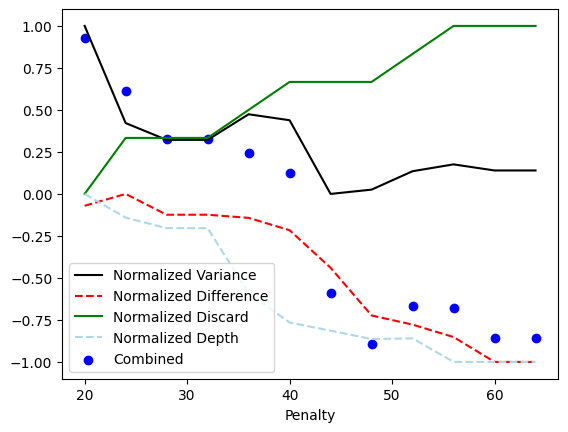

In [139]:
# plt.scatter(penalties,ybm_var,color='orange')
# plt.scatter(penalties,vars, color='k')
# plt.scatter(penalties,diff, color='r')
# plt.scatter(penalties,discard, color='g')
# plt.scatter(penalties, np.array(vars)-np.array(diff),color='b')
# print(penalties[np.where(vars == min(vars))[0][0]])
normvars = (np.array(vars)- min(vars))/(max(vars)-min(vars))
normdiff = (np.array(diff) - min(diff))/(max(diff)-min(diff))
normdepth = (np.array(maxdepth) - min(maxdepth))/(max(maxdepth)- min(maxdepth)) 
# plt.scatter(penalties, normdepth, color='lightblue')
normdiscard = (np.array(discard) - min(discard))/(max(1,max(discard)-min(discard)))
# # plt.scatter(penalties, normdiscard, color='b')
plt.plot(penalties,normvars, color='k')
plt.plot(penalties,-normdiff, color='r', linestyle='dashed')
plt.plot(penalties,normdiscard, color='g')
plt.plot(penalties, -normdepth, color='lightblue', linestyle='dashed')
# # combo = normvars - normdiff - 2*normdepth + 2*normdiscard
combo = normvars - normdiff - normdepth + normdiscard
plt.scatter(penalties,combo,color='b')
plt.xlabel('Penalty')
plt.legend(['Normalized Variance', 'Normalized Difference', 'Normalized Discard', 'Normalized Depth', 'Combined'], loc='lower left')
# print(penalties[np.where(combo == min(combo))[0][0]])


# print(np.where(vars == min(vars))[0][-1])
# # plt.scatter(range(len(vars)),vars,color='k')
# # plt.scatter(range(len(diff)),diff,color='r')
# plt.plot(range(len(combo)),normvars, color='k')
# plt.plot(range(len(combo)),-normdiff, color='r', linestyle='dashed')
# plt.plot(range(len(combo)),normdiscard, color='g')
# plt.plot(range(len(combo)), -normdepth, color='lightblue', linestyle='dashed')
# plt.scatter(range(len(combo)),combo,color='b')
# print(np.where(combo == min(combo))[0][0])

In [140]:
# ## re-run with optimal penalty 
# combo = normvars - normdiff
pen = penalties[np.where(combo == min(combo))[0][0]]
print(pen)
# # pen = penalties[np.where(vars == min(vars))[0][0]]
# threshold = 0
# pen_above = pen
# pen = 32

# # i = np.where(vars == min(vars))[0][0]
# i = np.where(combo == min(combo))[0][0]
# # i = 25
# # print(method)
# pen_above = penalties_above[(i // (len(penalties_below) * len(thresholds))) % len(penalties_above)]
# pen_below = penalties_below[(i // len(thresholds)) % len(penalties_below)]
# threshold = thresholds[i % len(thresholds)]
# print('below:',pen_below, 'above:',pen_above, 'threshold:',threshold)

# pen_0 = penalties_0[i // (len(penalties_1) * len(penalties_2) * len(thresholds_1) * len(thresholds_2))]
# pen_1 = penalties_1[(i // (len(penalties_2) * len(thresholds_1) * len(thresholds_2))) % len(penalties_1)]
# pen_2 = penalties_2[(i // (len(thresholds_1) * len(thresholds_2))) % len(penalties_2)]
# threshold1 = thresholds_1[(i // len(thresholds_2)) % len(thresholds_1)]
# threshold2 = thresholds_2[i % len(thresholds_2)]
# print('pen0:',pen_0, 'pen1:',pen_1, 'pen2:',pen_2, 'threshold1:',threshold1, 'threshold2:',threshold2)

cp_layers_dict = {}
results_k_values = {}
for bh in cpt:
    depth = cpt[bh]['CPT_data']['d']
    sbt = cpt[bh]['CPT_data']['SBT']  ## ['CPT_data'] for corrected data
    # Detect change points
    change_points = detect_change_points(cpt[bh]['CPT_data']['SBT'].values, model="l2", penalty=pen)[:-1]

    # if max(cpt[bh]['CPT_data']['d']) < threshold:
    #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_below)[:-1]
    # else:
    #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_above)[:-1]
        
    # if max(cpt[bh]['CPT_data']['d']) < threshold1:
    #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_0)[:-1]
    # elif max(cpt[bh]['CPT_data']['d']) < threshold2:
    #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_1)[:-1]
    # else:
    #     change_points = detect_change_points(sbt.values, model="l2", penalty=pen_2)[:-1]
    
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0

    # Calculate and plot the average k_fromIc between change points
    change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
    depths = []
    Ks = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i + 1]

        avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
        avg_SBT = stats.mode(cpt[bh]['CPT_data']['SBT'][start_idx:end_idx])[0]
        start_depth = cpt[bh]['CPT_data']['d'][start_idx]
        end_depth = cpt[bh]['CPT_data']['d'][end_idx]
        depths.append(end_depth - start_depth)
        Ks.append(avg_k_fromIc)
    if method == 'naive':  
        if fill_flag:
            if len(depths) == 3:
                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2]}
            elif len(depths) >= 4:
                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
            elif len(depths) ==2:
                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': np.nan}
            else:
                cp_layers_dict[bh] = {'Fill': depths[0],'Young Bay Mud': np.nan, 'Merrit Sand': np.nan} 
        else:
            if len(depths) >=3:
                cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
            elif len(depths) ==2:
                cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1]}
            else:
                cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': depths[0], 'Merrit Sand': np.nan}
    elif method == 'MS':
        if len(depths) == 3 + fill_flag:
            if fill_flag: 
                cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
            else:
                cp_layers_dict[bh] = {'Fill':0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
        elif len(depths) > 3 + fill_flag:
            ## this is where we have more layers than expected
            if fill_flag:
                # sum of depths from fill to merrit sand
                ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                else:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
            else:
                ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                else:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
        elif len(depths) < 3 + fill_flag:
            ## this is where we have fewer layers than expected
            if 6 not in SBTs:
                print('no sand in', bh)
                if fill_flag:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]), 'Merrit Sand': np.nan}
                else:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths), 'Merrit Sand': np.nan}
            else:
                MS_ind = np.where(np.array(SBTs) == 6)[0][-1]
                if fill_flag:
                    if len(depths) <=2:
                        print('throwing out', bh)
                        continue
                    elif MS_ind == 0:
                        ## there is only one layer with SBT 6, assume it is fill
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]), 'Merrit Sand': np.nan}
                    else:
                        if len(depths) > MS_ind+1:
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                        else:
                            cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind]}
                else:
                    if len(depths) <=1:
                        print('throwing out', bh)
                        continue
                    else:
                        if len(depths) > MS_ind+1:
                            cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                        else:
                            cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind]}
    elif method == 'MS_AF':
        if len(depths) == 3 + fill_flag:
            if fill_flag: 
                if depths[0] <= af_lim:
                    cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': depths[1], 'Merrit Sand': depths[2], 'Below Merrit Sand': depths[3]}
                else:
                    cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
            else:
                cp_layers_dict[bh] = {'Fill':0, 'Young Bay Mud': depths[0], 'Merrit Sand': depths[1], 'Below Merrit Sand': depths[2]}
        if len(depths) > 3 + fill_flag:
            ## we have more layers than expected
            if fill_flag:
                # sum of depths from fill to merrit sand
                if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                    if depths[0] <= af_lim:
                        ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                    else:
                        ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                        cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                else:
                    if depths[0] <= af_lim:
                        ybm_depth = sum(depths[1:np.where(np.array(SBTs) == 6)[0][-1]])
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
                    else:
                        ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                        cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
            else:
                ybm_depth = sum(depths[:np.where(np.array(SBTs) == 6)[0][-1]])
                if len(depths) > np.where(np.array(SBTs) == 6)[0][-1]+1:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]], 'Below Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]+1]}
                else:
                    cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': ybm_depth, 'Merrit Sand': depths[np.where(np.array(SBTs) == 6)[0][-1]]}
        elif len(depths) < 3 + fill_flag:
            ## case where we have fewer layers than expected
            try:
                MS_ind = np.where(np.array(SBTs) == 6)[0][-1]
            except:
                print('no sand in', bh)
                continue
            if fill_flag:
                if len(depths) <=2:
                    print('throwing out', bh)
                    continue
                elif MS_ind == 0:
                    ## there is only one layer with SBT 6, check its depth
                    if depths[0] <= af_lim:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:]),'Merrit Sand': np.nan}
                    else:
                        cp_layers_dict[bh] = {'Fill': np.nan, 'Young Bay Mud': 0, 'Merrit Sand': np.sum(depths[MS_ind]), 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                else:
                    if len(depths) > MS_ind+1:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                    else:
                        cp_layers_dict[bh] = {'Fill': depths[0], 'Young Bay Mud': np.sum(depths[1:MS_ind]), 'Merrit Sand': depths[MS_ind]}
            else: ## not in fill
                if len(depths) <=1:
                    print('throwing out', bh)
                    continue
                else:
                    if len(depths) > MS_ind+1:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind], 'Below Merrit Sand': np.sum(depths[MS_ind+1:])}
                    else:
                        cp_layers_dict[bh] = {'Fill': 0, 'Young Bay Mud': np.sum(depths[:MS_ind]), 'Merrit Sand': depths[MS_ind]}

    ## still within borehole
    fill_thickness = cp_layers_dict[bh]['Fill']
    ybm_thickness = cp_layers_dict[bh]['Young Bay Mud']
    ms_thickness = cp_layers_dict[bh]['Merrit Sand']
    fill_depth = fill_thickness  # Fill layer goes from 0 to fill_thickness
    ybm_depth = fill_depth + ybm_thickness  # Young Bay Mud goes from fill_depth to fill_depth + ybm_thickness
    ms_depth = ybm_depth + ms_thickness  # Merritt Sand goes from ybm_depth to ybm_depth + ms_thickness
    
    # Calculate average k_fromIc for each layer, excluding NaN values
    results_k_values[bh] = {}
    # Fill layer
    fill_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] <= fill_depth)]['k_fromIc'].dropna()
    results_k_values[bh]['Fill'] = fill_values.mean() if not fill_values.empty else 0  # Default to 0 if no data points
    # Young Bay Mud layer
    ybm_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > fill_depth) & (cpt[bh]['CPT_data']['d'] <= ybm_depth)]['k_fromIc'].dropna()
    results_k_values[bh]['Young Bay Mud'] = ybm_values.mean() if not ybm_values.empty else 0  # Default to 0 if no data points
    # Merritt Sand layer
    ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ybm_depth) & (cpt[bh]['CPT_data']['d'] <= ms_depth)]['k_fromIc'].dropna()
    results_k_values[bh]['Merritt Sand'] = ms_values.mean() if not ms_values.empty else 0  # Default to 0 if no data points
    # Below Merritt Sand
    below_ms_values = cpt[bh]['CPT_data'][(cpt[bh]['CPT_data']['d'] > ms_depth)]['k_fromIc'].dropna()
    results_k_values[bh]['Below Merritt Sand'] = below_ms_values.mean() if not below_ms_values.empty else 0  # Default to 0 if no data points
    # Transform data to log scale
results_k_values = pd.DataFrame(results_k_values).transpose()
results_k_m_day = results_k_values.apply(lambda x: x*86400)
log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)

cp_layers_df = pd.DataFrame.from_dict(cp_layers_dict, orient='index')

48
throwing out ALC018
throwing out ALC019
throwing out ALC020
throwing out ALC021
throwing out ALC022
throwing out ALC023
throwing out ALC024
throwing out ALC025
throwing out ALC026
throwing out ALC029
throwing out ALC031
throwing out ALC032


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\1689199616.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_results_k_df = results_k_m_day.applymap(lambda x: np.log10(x) if x > 0 else np.nan)


C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\888946114.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\888946114.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\888946114.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
C:\Users\Emily\AppData\Local\Temp\ipykernel_24240\888946114.py:37: UserWarning: set_ticklabels() sho

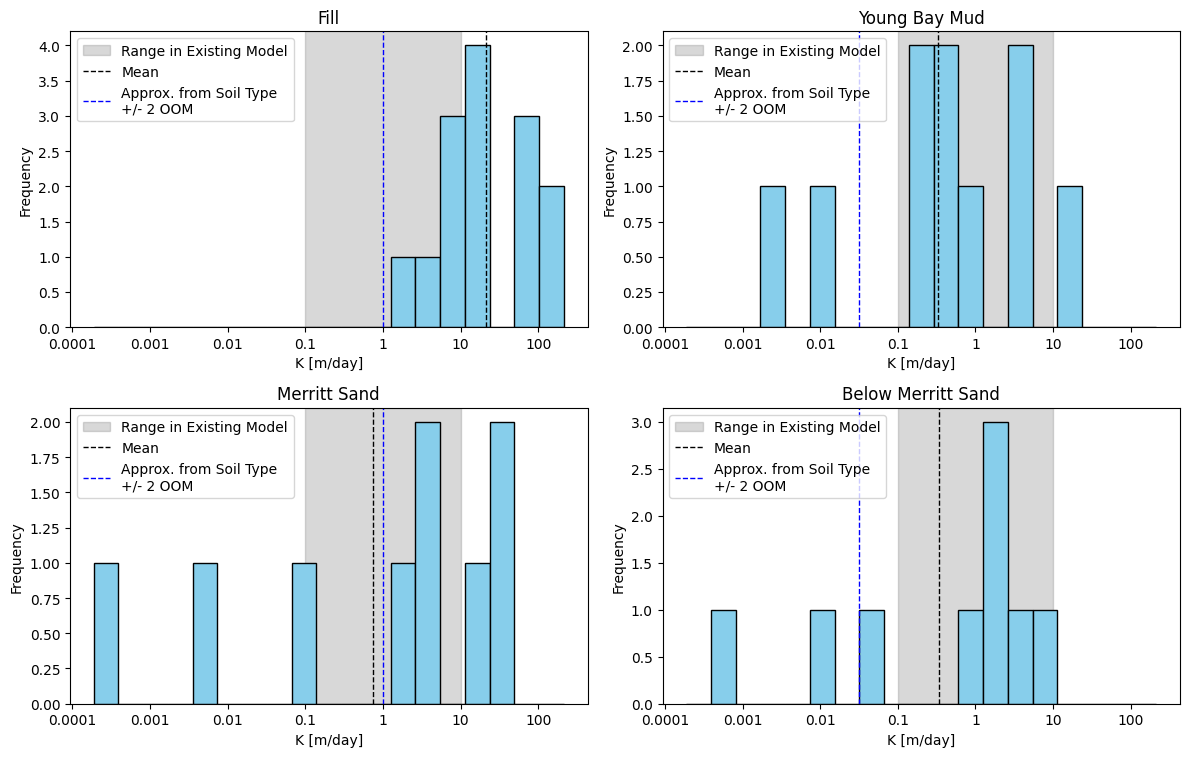

In [141]:
# Define linear bins in log-transformed space
min_value = log_results_k_df.min().min()
max_value = log_results_k_df.max().max()
bins = np.linspace(min_value, max_value, 20)  # 20 linear bins in log-transformed space

# Placeholder for custom values: Fill, Young Bay Mud, Merritt Sand, Below Merritt Sand
custom_values = [0,-1.5,0,-1.5]  # To be filled with specific log-scaled values as needed

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms for each layer with additional features
layer_names = ['Fill', 'Young Bay Mud', 'Merritt Sand', 'Below Merritt Sand']
for i, (ax, layer) in enumerate(zip(axes.flatten(), layer_names)):
    # Calculate mean for the layer (ignoring NaN values)
    layer_data = log_results_k_df[layer].dropna()
    mean_value = layer_data.mean()

    # Add a shaded region between log10(0.1) and log10(10)
    ax.axvspan(np.log10(0.1), np.log10(10), color='grey', alpha=0.3, label='Range in Existing Model')

        
    # Plot histogram
    ax.hist(layer_data, bins=bins, color='skyblue', edgecolor='black')
    ax.set_title(f'{layer}')
    ax.set_xlabel('K [m/day]')
    ax.set_ylabel('Frequency')
    
    # Plot vertical dashed line for the mean
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=1, label='Mean')
    
    # Plot vertical dashed line for custom values (if custom values are provided)
    if custom_values:
        ax.axvline(custom_values[i], color='blue', linestyle='--', linewidth=1, label='Approx. from Soil Type \n+/- 2 OOM')

    # Automatically adjust x-axis tick labels to show values in original scale
    ticks = ax.get_xticks()  # Get the current ticks in log scale
    ax.set_xticklabels([f"{10**tick:.3g}" for tick in ticks])  # Convert back to original scale and format
    
    # Add legend
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
plt.show()


c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Emily\miniconda3\envs\Kh_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


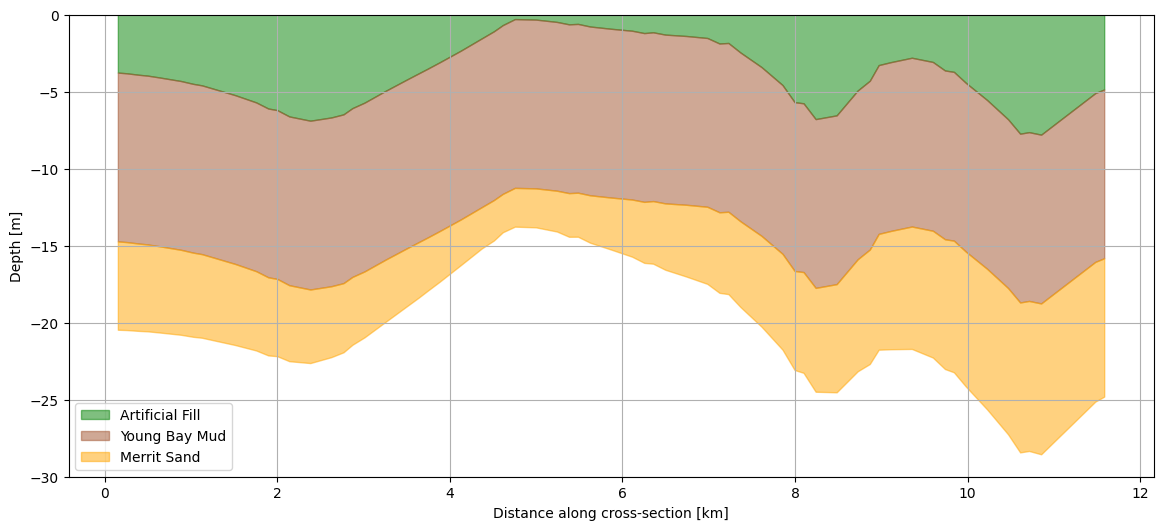

In [142]:
## get cp_layers_df lat lon from cpt dict
cp_layers_df['Lat'] = cp_layers_df.index.map(lambda x: cpt[x]['Lat'])
cp_layers_df['Lon'] = cp_layers_df.index.map(lambda x: cpt[x]['Lon'])
gdf_layers_naive = gpd.GeoDataFrame(cp_layers_df, geometry=gpd.points_from_xy(cp_layers_df['Lon'], cp_layers_df['Lat']), crs='EPSG:4326')
gdf_layers_naive = gpd.sjoin(gdf_layers_naive,data , how='left')
gdf_layers_naive.loc[~gdf_layers_naive['PTYPE'].isin(['H2O','afem']),'Fill'] = 0

# Define the bounds of the grid
minx, miny, maxx, maxy = gdf_layers_naive.total_bounds

# Create a grid of points within these bounds
spacing = 0.008  # Define spacing between grid points (adjust as needed)
x_coords = np.arange(minx, maxx, spacing)
y_coords = np.arange(miny, maxy, spacing)
grid_points = [Point(x, y) for x in x_coords for y in y_coords]

# Convert grid points to a GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs=gdf_layers_naive.crs)

# Filter out grid points that overlap with 'H2O' or 'afem' regions in data
filtered_gdf = grid_gdf[~grid_gdf.sjoin(data[data['PTYPE'].isin(['H2O', 'afem'])], how='left', predicate='intersects').index_right.notnull()]

# Assign a depth value of 0 to these new points
filtered_gdf['Fill'] = 0

# Add these new points to geo_layers
geo_layers_append_naive = pd.concat([gdf_layers_naive, filtered_gdf], ignore_index=True)
geo_layers_append_naive[['UTM -X', 'UTM -Y']] = geo_layers_append_naive['geometry'].apply( lambda point: pd.Series(utm.from_latlon(point.y, point.x)[:2]))
geo_layers_append_naive['UTM -X'] = pd.to_numeric(geo_layers_append_naive['UTM -X'], errors='coerce')
geo_layers_append_naive['UTM -Y'] = pd.to_numeric(geo_layers_append_naive['UTM -Y'], errors='coerce')
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')

# Drop any rows in points with non-numeric values
points = points.dropna(subset=['utmX', 'utmY'])

# Interpolation for each depth field
kriged_depths = {}

for depth_type in ['Fill', 'Young Bay Mud', 'Merrit Sand']:
    # Ensure depth values are numeric
    geo_layers_append_naive[depth_type] = pd.to_numeric(geo_layers_append_naive[depth_type], errors='coerce')
    
    # Filter out rows with NaN in UTM coordinates or the depth column
    valid_layers = geo_layers_append_naive.dropna(subset=['UTM -X', 'UTM -Y', depth_type])
    
    # Extract valid coordinates and depth values
    x_coords = valid_layers['UTM -X'].values.astype(float)
    y_coords = valid_layers['UTM -Y'].values.astype(float)
    z_values = valid_layers[depth_type].values.astype(float)
    
    if len(x_coords) > 0 and len(y_coords) > 0 and len(z_values) > 0:
        # Perform kriging
        kriging_model = OrdinaryKriging(
            x_coords, y_coords, z_values,
            variogram_model='exponential',  ## exponential, gaussian, linear, spherical 
            verbose=False,
            nlags = 20, 
            enable_plotting=False
        )
        
        # Interpolate depths at the points of interest
        z_interp, _ = kriging_model.execute(
            'points', 
            points['utmX'].values.astype(float), 
            points['utmY'].values.astype(float)
        )
        
        kriged_depths[depth_type] = z_interp.clip(0)

# Add kriged results to points DataFrame
for depth_type, values in kriged_depths.items():
    points[depth_type] = values

# Assuming 'points' is your DataFrame and is already a GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    points,
    geometry=gpd.points_from_xy(points['lon'], points['lat']),
    crs="EPSG:4326"  # Ensure this matches your coordinate reference system
)

# Define a line for the cross-section (choose points based on your requirements)
line = LineString([(points_gdf['geometry'].x.min(), points_gdf['geometry'].y.max()),
                   (points_gdf['geometry'].x.max(), points_gdf['geometry'].y.min())])


# Find the points that are closest to or intersect the line
points_gdf['distance_to_line'] = points_gdf.geometry.apply(lambda point: point.distance(line))
points_near_line = points_gdf[points_gdf['distance_to_line'] <= 0.0003]  # Adjust the threshold as needed

# Sort the points along the line
points_near_line['distance_along_line'] = points_near_line.geometry.apply(lambda point: line.project(point))*100
points_near_line = points_near_line.sort_values('distance_along_line')

# Plot the cross-section using the selected points
plt.figure(figsize=(14, 6))

# Plot each geological layer as a filled polygon
plt.fill_between(
    points_near_line['distance_along_line'], 
    0,  # Ground level (adjust if needed)
    -points_near_line['Fill'],  # Use negative for depth below ground
    color='green', alpha=0.5, label='Artificial Fill'
)
plt.fill_between(
    points_near_line['distance_along_line'], 
    -points_near_line['Fill'], -points_near_line['Fill'] -points_near_line['Young Bay Mud'],
    color='sienna', alpha=0.5, label='Young Bay Mud'
)
plt.fill_between(
    points_near_line['distance_along_line'], 
    -points_near_line['Fill'] -points_near_line['Young Bay Mud'], -points_near_line['Fill'] -points_near_line['Young Bay Mud'] -points_near_line['Merrit Sand'],
    color='orange', alpha=0.5, label='Merrit Sand'
)

# Customization
plt.xlabel('Distance along cross-section [km]')
plt.ylabel('Depth [m]')
plt.ylim(-30, 0)
# plt.title('Cross Section of Geological Layers in Alameda')
plt.legend()
plt.grid(True)

# Display the cross-section plot
plt.show()



<Axes: >

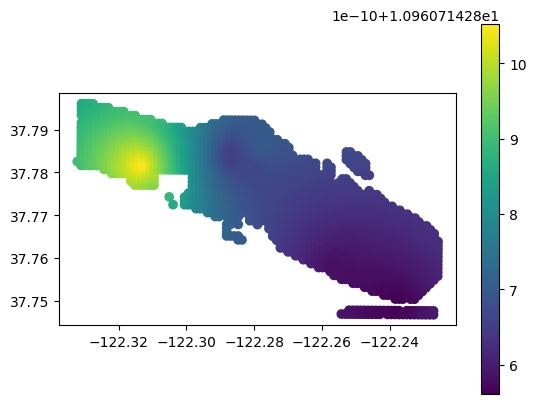

In [143]:
points.plot(column='Young Bay Mud',legend=True)